In [2]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils_io import *
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.process import generate_grid_prompt
from src.models.magic_pen.task import MagicPenModule

## Count nombre de paramètres

In [3]:
def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(
        config_name="eval", 
        overrides=["experiment=adapter_diff", 
                   "sam_type=small", 
                   "data=levir-cd",
                  ])
    
    return cfg
from hydra.core.global_hydra import GlobalHydra

def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()
    
GlobalHydra.instance().clear()
cfg = load_config()

In [13]:
model = hydra.utils.instantiate(cfg.model.instance.network)

INIT ADAPTER VIT


2024-08-26 22:16:40,422 - INFO ::  Weights loaded for : ['image_encoder']


In [14]:
mask_decoder = model.mask_decoder

In [15]:
sum(p.numel() for p in mask_decoder.parameters() if p.requires_grad)

3925728

In [16]:
prompt_encoder = model.prompt_encoder

In [17]:
sum(p.numel() for p in prompt_encoder.parameters() if p.requires_grad)

1024

In [18]:
image_encoder = model.image_encoder

In [19]:
sum(p.numel() for p in image_encoder.parameters() if p.requires_grad)

156768

### Check prediction

In [4]:
_SHARE_PATH = "levir-cd/vit-b"

def _cfg_meta(exp_name, id_exp, folder_root=None, description=""):
    """generate register items - to be updated"""
    if folder_root is None: folder_root = ""
    cfg = {
        "path": make_path(
                    id_exp, 
                    LOGS_PATH, 
                    "final_logs",
                    folder_root,
                    exp_name,
                    _SHARE_PATH
                ),
        "description": description
    }

    if not os.path.exists(cfg["path"]): 
        raise FileNotFoundError(f"Exp run logs not found :{cfg['path']}")
    return cfg

# TODO: integrate in src/
_register_runs = {
    # PROBING
    "probing_concat_baseline": 
        _cfg_meta("train_probing_concat", "2024-08-07_17-50-07", folder_root="08082024_train_first_modules", description=""),
    "probing_diff_baseline":
        _cfg_meta("train_probing_diff", "2024-08-07_17-50-30", folder_root="08082024_train_first_modules", description=""),
    "probing_attn_baseline":
        _cfg_meta("train_probing_attn", "2024-08-07_17-51-53", folder_root="08082024_train_first_modules", description=""),
    # ADAPTER
    "adapter_diff":
        _cfg_meta("train_adapter_diff", "2024-08-07_17-52-31", folder_root="08082024_train_first_modules", description=""),
    "adapter_concat":
        _cfg_meta("train_adapter_concat", "2024-08-07_17-53-32", folder_root="08082024_train_first_modules", description=""),
    "adapter_attn":
        _cfg_meta("train_adapter_attn", "2024-08-07_18-15-08", folder_root="08082024_train_first_modules", description=""),
    # LORA
    "lora_diff":
        _cfg_meta("train_lora_diff", "2024-08-07_18-22-22", folder_root="08082024_train_first_modules", description=""),
    "lora_concat":
        _cfg_meta("train_lora_concat", "2024-08-07_18-21-49", folder_root="08082024_train_first_modules", description=""),
    "lora_attn":
        _cfg_meta("train_lora_attn", "2024-08-07_18-22-20", folder_root="08082024_train_first_modules", description=""),
    "lora_attnconc_focal_dice_lr5x10-4":
        _cfg_meta("lora_attnconc_focal_dice_lr5x10-4", "1448002", folder_root="", description=""),
    # EXPLO lr ADAPTER
    "adapter_attnconc_bce_lr3x10-4":
        _cfg_meta("adapter_attnconc_bce_lr3x10-4", "1387852", folder_root="", description=""),
    "adapter_attnconc_bce_lr10-4":
        _cfg_meta("adapter_attnconc_bce_lr10-4", "1380222", folder_root="", description=""),
    "adapter_attnconc_bce_lr5x10-4":
        _cfg_meta("adapter_attnconc_bce_lr5x10-4", "1447907", folder_root="", description=""),
    "adapter_attnconc_focal_dice_lr5x10-4":
        _cfg_meta("adapter_attnconc_focal_dice_lr5x10-4", "1447968", folder_root="", description=""),


}


In [5]:
ds_name = "levir-cd"

folder_logs = make_path("instances", PROJECT_PATH, "reports", "scores", ds_name)
all_scores = []

metric_max = "BinaryF1Score"

for exp_name in os.listdir(folder_logs):
    if not os.path.exists(make_path(f"{exp_name}.csv", folder_logs, exp_name)):
        print(f"{exp_name} logs file not found - please run evaluation")
        continue
    df = pd.read_csv(make_path(f"{exp_name}.csv", folder_logs, exp_name), index_col=0)
    metrics_col = [_ for _ in df.columns if _ not in ["label_path", "th"]]
    scores = df.groupby("th")[metrics_col].mean().round(3).mul(100).reset_index()
    row = scores[scores.index == scores[metric_max].idxmax()]
    row.index = [exp_name]
    all_scores.append(row)

all_scores = pd.concat(all_scores).sort_values("BinaryF1Score", ascending=False)
all_scores

lora_diff logs file not found - please run evaluation


,th,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
adapter_concat,0.4,74.9,72.3,76.0,75.0
adapter_attnconc_bce_lr3x10-4,0.3,74.4,71.3,75.0,74.5
adapter_attnconc_bce_lr10-4,0.4,74.0,71.3,75.2,73.9
adapter_diff,0.4,73.9,71.2,74.8,74.2
lora_concat_k32,0.2,61.6,52.6,60.8,64.3
probing_concat_baseline,0.3,60.3,51.7,63.2,62.0
lora_concat,0.2,55.0,45.8,58.7,55.3
probing_diff_baseline,0.3,50.2,39.5,55.1,52.1
lora_attnconc_focal_dice_lr5x10-4,0.1,47.1,38.4,47.7,51.7


In [6]:
exp_name = "adapter_concat"
df = pd.read_csv(make_path(f"{exp_name}.csv", folder_logs, exp_name), index_col=0)
df = df[df.th == 0.4]

In [17]:
df[df["BinaryF1Score"] > 0.][metrics_col].mean()

BinaryF1Score         0.855576
BinaryJaccardIndex    0.761482
BinaryRecall          0.868260
BinaryPrecision       0.856713
dtype: float64

Text(0.5, 1.0, 'Distribution des f1-scores du jeu de test - Modèle adapter_concat')

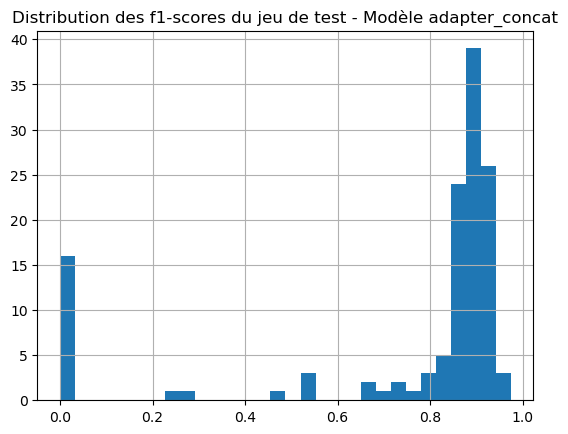

In [18]:
df["BinaryF1Score"].hist(bins=30)
plt.title("Distribution des f1-scores du jeu de test - Modèle adapter_concat")

In [14]:
null_scores = df[df["BinaryF1Score"] == 0.]

In [20]:
print("Worst predictions :", len(null_scores["label_path"]))
for l in list(null_scores["label_path"]):
    label = load_img(l)
    print("Label px change :" , np.sum(label))

Worst predictions : 16
Label px change : 58650
Label px change : 0
Label px change : 47175
Label px change : 0
Label px change : 66810
Label px change : 0
Label px change : 0
Label px change : 0
Label px change : 146115
Label px change : 0
Label px change : 143055
Label px change : 61200
Label px change : 0
Label px change : 0
Label px change : 0
Label px change : 0


In [22]:
print("No label in test")
no_label_cnt = 0
no_label_path = []
for l in list(df["label_path"]):
    label = load_img(l)
    if not np.sum(label):
        no_label_cnt +=1
        no_label_path.append(l)
print(f"Sample in test with no label :", no_label)

No label in test
Sample in test with no label : 10


In [24]:
df[~df["label_path"].isin(no_label_path)][metrics_col].mean()

BinaryF1Score         0.812072
BinaryJaccardIndex    0.722763
BinaryRecall          0.824111
BinaryPrecision       0.813151
dtype: float64